Vicky Pagarani


Only for reference to hyper tuning using pipeline object of neighbours and sigma with models(above [29])


In [3]:
#imports for the entire project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, silhouette_score, davies_bouldin_score

#for a cleaner look in plots
plt.style.use('seaborn-v0_8-whitegrid')
#to ignore warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully.")

Libraries imported successfully.


In [4]:
#Data Loading and Inspection
print("--- I. Data Loading and Inspection ---")

#Loading the dataset
df_raw = pd.read_csv('C:/Users/Zer0/Documents/mkd.csv', index_col=0) # Ensure this path is correct for your environment
df = df_raw.copy() # copy df


#basic info
print("\nFirst 5 rows of the dataset:")
print(df.head())

print(f"\nShape of the dataset (rows, columns): {df.shape}")

print("\nData types of columns:")
print(df.info())

print("\nSummary stats for numerical columns:")
print(df.describe())

print("\nSummary stats for object columns:")
print(df.describe(include='object'))

print("\nNumber of unique values in each column:")
for col in df.columns:
    print(f"- {col}: {df[col].nunique()} unique values")

--- I. Data Loading and Inspection ---

First 5 rows of the dataset:
   Size Size_unit      Property_type          Location Seller_name  \
0     2       BHK  Independent Floor       Uttam Nagar      seller   
1     3       BHK  Independent House        Model Town      seller   
2     2       BHK          Apartment  Sector 13 Rohini      seller   
3     3       BHK          Apartment         DLF Farms      seller   
4     3       BHK  Independent Floor       laxmi nagar      seller   

      Seller_type Rent_price  Area_sqft          Status Security_deposit  \
0  Verified Owner      8,500        500  Semi-Furnished               No   
1  Verified Owner     48,000       1020       Furnished               No   
2  Verified Owner     20,000        810     Unfurnished               No   
3  Verified Owner     11,000        750  Semi-Furnished               No   
4  Verified Owner     20,000       1300       Furnished               No   

   Bathroom Facing_direction  
0       1.0        Nor

In [5]:
print("--- Data Cleaning and Preprocessing ---")

# 1. Get the initial number of rows
initial_rows = df.shape[0]

# 2. Drop duplicate rows
df.drop_duplicates(inplace=True)

# 3. Print information about dropped duplicates
print(f"\nDropped {initial_rows - df.shape[0]} duplicate rows.")
print(f"Shape after dropping duplicates: {df.shape}")

--- Data Cleaning and Preprocessing ---

Dropped 3827 duplicate rows.
Shape after dropping duplicates: (10173, 12)


In [6]:
#Removing irrelevant columns
columns_to_drop_next = [] # Use a different name to avoid confusion if cell is re-run

if 'Seller_name' in df.columns:
    columns_to_drop_next.append('Seller_name')
if 'Security_deposit' in df.columns:
    columns_to_drop_next.append('Security_deposit') #caused  target leakage and overfitting

if columns_to_drop_next:
    df.drop(columns=columns_to_drop_next, axis=1, inplace=True)
    print(f"Dropped columns: {columns_to_drop_next}")
else:
    print("No further columns to drop (Seller_name, Security_deposit).")


print("\nDataFrame columns after dropping:")
print(df.columns)


Dropped columns: ['Seller_name', 'Security_deposit']

DataFrame columns after dropping:
Index(['Size', 'Size_unit', 'Property_type', 'Location', 'Seller_type',
       'Rent_price', 'Area_sqft', 'Status', 'Bathroom', 'Facing_direction'],
      dtype='object')


In [7]:
# 1. Gets the initial number of rows BEFORE cleaning
initial_rows = df.shape[0]
#Logs how many rows have 'Size' exactly equal to 0
if 'Size' in df.columns:
    print(f"Number of rows where 'Size' is exactly 0: {(df['Size'] == 0).sum()}")

    # 2. Filters out rows where 'Size' is exactly 0
    df = df[df['Size'] != 0]

    rows_removed = initial_rows - df.shape[0]
    print(f"Initial number of rows: {initial_rows}")
    print(f"Removed {rows_removed} rows where 'Size' was exactly 0.")
    print(f"New shape of DataFrame: {df.shape}")
else:
    print("Column 'Size' not found.")

Number of rows where 'Size' is exactly 0: 3
Initial number of rows: 10173
Removed 3 rows where 'Size' was exactly 0.
New shape of DataFrame: (10170, 10)


In [8]:
if 'Size' in df.columns:
    print(df['Size'].min())

1


In [9]:
#Converts 'Rent_price' to numeric
if 'Rent_price' in df.columns:
    print(f"\n'Rent_price' column before conversion (first 5): \n{df['Rent_price'].head()}")
    print(f"Data type of 'Rent_price' before: {df['Rent_price'].dtype}")

    def convert_price_to_numeric(price_str):
        price_str = str(price_str).replace(',', '') # Ensure it's a string before replace
        price_str = price_str.strip().upper()
        if 'L' in price_str:
            return float(price_str.replace('L', '')) * 100000
        return float(price_str)
        
    df['Rent_price'] = df['Rent_price'].apply(convert_price_to_numeric)
        
    print(f"\n'Rent_price' column after conversion (first 5): \n{df['Rent_price'].head()}")
    print(f"Data type of 'Rent_price' after: {df['Rent_price'].dtype}")
else:
    print("Column 'Rent_price' not found.")


'Rent_price' column before conversion (first 5): 
0     8,500
1    48,000
2    20,000
3    11,000
4    20,000
Name: Rent_price, dtype: object
Data type of 'Rent_price' before: object

'Rent_price' column after conversion (first 5): 
0     8500.0
1    48000.0
2    20000.0
3    11000.0
4    20000.0
Name: Rent_price, dtype: float64
Data type of 'Rent_price' after: float64


In [10]:
from sklearn.impute import KNNImputer
print("--- KNN Imputation for 'Bathroom' and related features ---")
num_features_for_knn = ['Bathroom', 'Area_sqft', 'Size']
    
# Check if all required columns exist
if all(col in df.columns for col in num_features_for_knn):
    print(f"Selected numerical features for KNN: {num_features_for_knn}")

    df_subset_knn = df[num_features_for_knn].copy()
            
    original_index = df_subset_knn.index
    original_columns = df_subset_knn.columns

    scaler_knn = StandardScaler() # Use a different name for this scaler

    scaled_values_array = scaler_knn.fit_transform(df_subset_knn)
            
    df_scaled_for_knn = pd.DataFrame(scaled_values_array, columns=original_columns, index=original_index)
            
    print("\nSample of scaled data before KNN imputation:")
    print(df_scaled_for_knn.head())

    knn_imputer = KNNImputer(n_neighbors=5) 
        
    imputed_scaled_values_array = knn_imputer.fit_transform(df_scaled_for_knn) 

    print("\nSample of scaled and imputed data (NumPy array from KNNImputer):")
    print(imputed_scaled_values_array[:5]) 

    imputed_original_scale_array = scaler_knn.inverse_transform(imputed_scaled_values_array)
            
    df_imputed_original_scale = pd.DataFrame(imputed_original_scale_array, columns=original_columns, index=original_index)

    print("\nSample of imputed data (back to original scale):")
    print(df_imputed_original_scale.head())

    for col in original_columns:
        df[col] = df_imputed_original_scale[col]

    print(f"\nOriginal DataFrame 'df' updated with KNN imputed values for columns: {original_columns}.")
    print("Missing values count after KNN imputation for selected columns:")
    print(df[num_features_for_knn].isnull().sum())
else:
    print(f"One or more columns for KNN imputation not found in DataFrame: {num_features_for_knn}")

--- KNN Imputation for 'Bathroom' and related features ---
Selected numerical features for KNN: ['Bathroom', 'Area_sqft', 'Size']

Sample of scaled data before KNN imputation:
   Bathroom  Area_sqft      Size
0 -1.232181  -1.107162 -0.902441
1  0.843545  -0.882647 -0.072094
2 -0.194318  -0.973316 -0.902441
3 -1.232181  -0.999222 -0.072094
4 -0.194318  -0.761754 -0.072094

Sample of scaled and imputed data (NumPy array from KNNImputer):
[[-1.23218077 -1.1071621  -0.90244088]
 [ 0.84354517 -0.88264662 -0.07209403]
 [-0.1943178  -0.97331633 -0.90244088]
 [-1.23218077 -0.99922197 -0.07209403]
 [-0.1943178  -0.76175367 -0.07209403]]

Sample of imputed data (back to original scale):
   Bathroom  Area_sqft  Size
0       1.0      500.0   2.0
1       3.0     1020.0   3.0
2       2.0      810.0   2.0
3       1.0      750.0   3.0
4       2.0     1300.0   3.0

Original DataFrame 'df' updated with KNN imputed values for columns: Index(['Bathroom', 'Area_sqft', 'Size'], dtype='object').
Missing valu

In [11]:
if 'Facing_direction' in df.columns:
    print(f"Handling 'Facing_direction' with {df['Facing_direction'].isnull().sum()} missing values ({df['Facing_direction'].isnull().mean()*100:.2f}%).")
        
    fill_value = "Unknown"
    df['Facing_direction'].fillna(fill_value, inplace=True)
        
    print(f"Imputed 'Facing_direction' NaNs with '{fill_value}'.")
    print(df['Facing_direction'].value_counts(dropna=False))
else:
    print("Column 'Facing_direction' not found.")

Handling 'Facing_direction' with 7938 missing values (78.05%).
Imputed 'Facing_direction' NaNs with 'Unknown'.
Facing_direction
Unknown      7938
NorthEast     670
East          543
North         345
West          177
NorthWest     170
South         128
SouthEast     124
SouthWest      75
Name: count, dtype: int64


In [12]:
if 'Property_type' in df.columns:
    print(df['Property_type'].value_counts())
    wrong_value='ApartmentApartment' 
    correct_value='Apartment'
    df['Property_type']=df['Property_type'].replace(wrong_value, correct_value)
    print(f"Replaced '{wrong_value}' with '{correct_value}' in 'Property_type'.")
    print(df['Property_type'].value_counts())
else:
    print("Column 'Property_type' not found.")

Property_type
Independent Floor     6275
Apartment             1734
Villa                 1124
Independent House      688
Studio Apartment       288
Penthouse               60
ApartmentApartment       1
Name: count, dtype: int64
Replaced 'ApartmentApartment' with 'Apartment' in 'Property_type'.
Property_type
Independent Floor    6275
Apartment            1735
Villa                1124
Independent House     688
Studio Apartment      288
Penthouse              60
Name: count, dtype: int64


In [13]:
if 'Size_unit' in df.columns:
    print(df['Size_unit'].value_counts())
    wrong_value='BHKBHK' 
    correct_value='BHK'
    df['Size_unit']=df['Size_unit'].replace(wrong_value, correct_value)
    print(f"Replaced '{wrong_value}' with '{correct_value}' in 'Size_unit'.")
    print(df['Size_unit'].value_counts())
else:
    print("Column 'Size_unit' not found.")

Size_unit
BHK       9876
RK         288
BHKBHK       6
Name: count, dtype: int64
Replaced 'BHKBHK' with 'BHK' in 'Size_unit'.
Size_unit
BHK    9882
RK      288
Name: count, dtype: int64


In [14]:
if 'Bathroom' in df.columns:
    num_decimals = (df['Bathroom'] != np.floor(df['Bathroom'])).sum()
    if num_decimals > 0:
        print(f"Found approximately {num_decimals} decimal values in 'Bathroom' column.")

    df['Bathroom'] = df['Bathroom'].round(0).astype(int) 

    print(f"Unique values in 'Bathroom' after rounding : {np.sort(df['Bathroom'].unique())}")
else:
    print("Column 'Bathroom' not found.")

Found approximately 2400 decimal values in 'Bathroom' column.
Unique values in 'Bathroom' after rounding : [1 2 3 4 5 6 7 8 9]


In [15]:
print("\nPreprocessing (initial cleaning) complete.")
df_cleaned = df.copy()


Preprocessing (initial cleaning) complete.


--- III. Exploratory Data Analysis (EDA) ---

Analyzing target variable 'Rent_price':


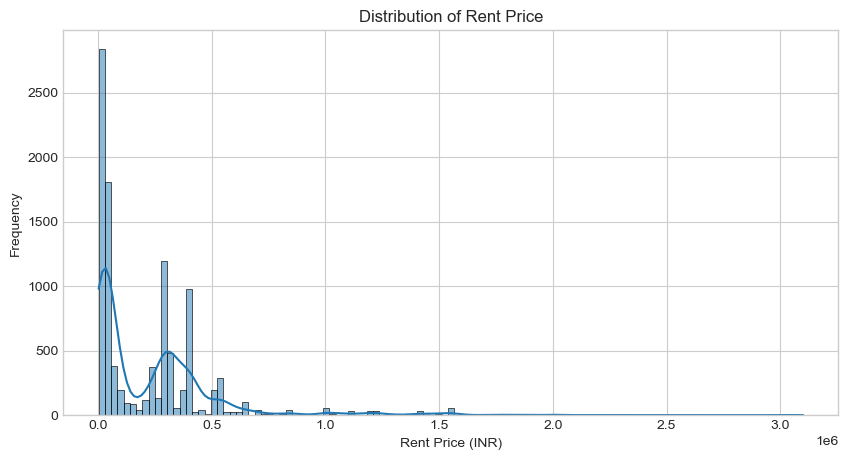

Rent Price Skewness: 2.94

Analyzing 'Area_sqft':


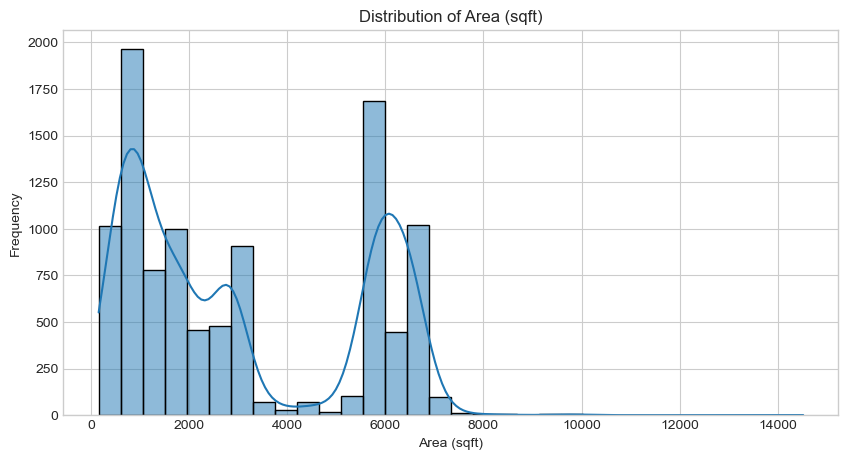


Analyzing 'Bathroom' counts:


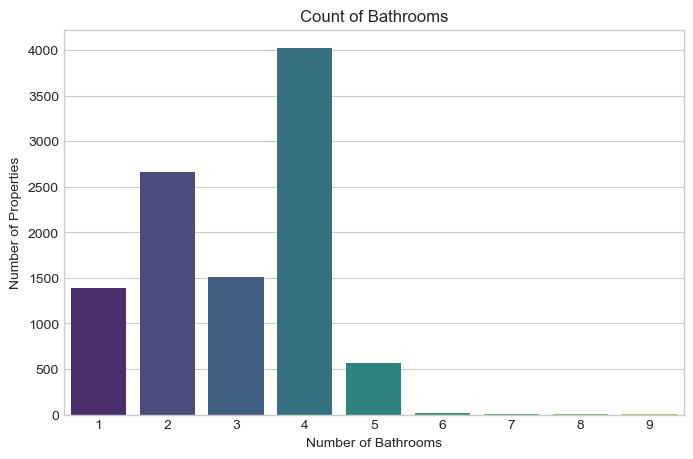


Analyzing 'Property_type':


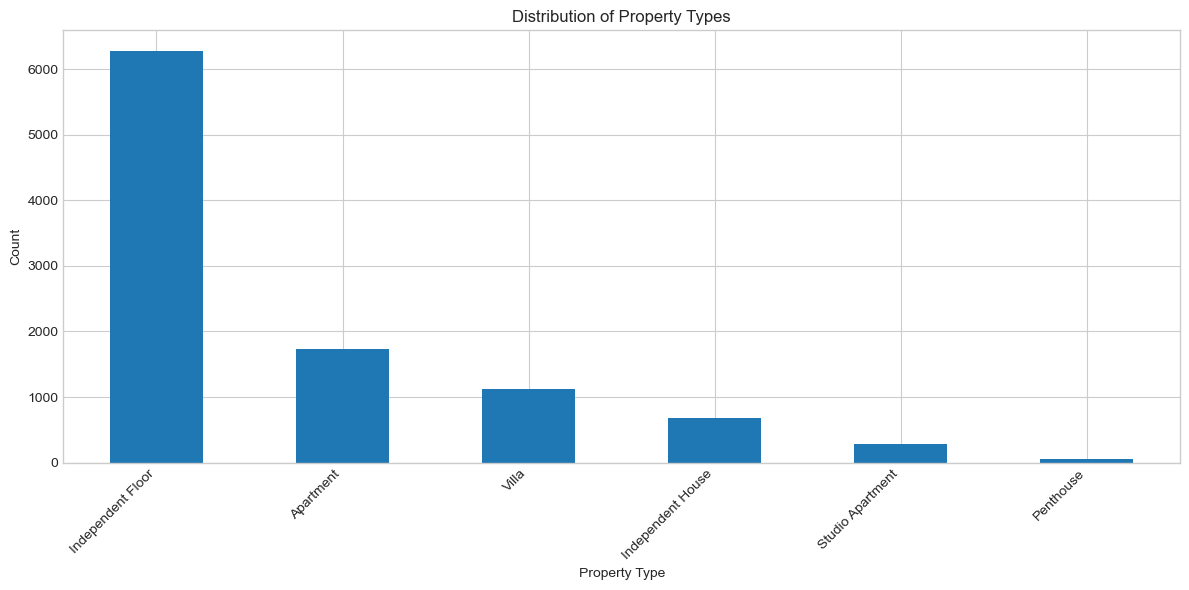


Rent Price vs. Area_sqft:


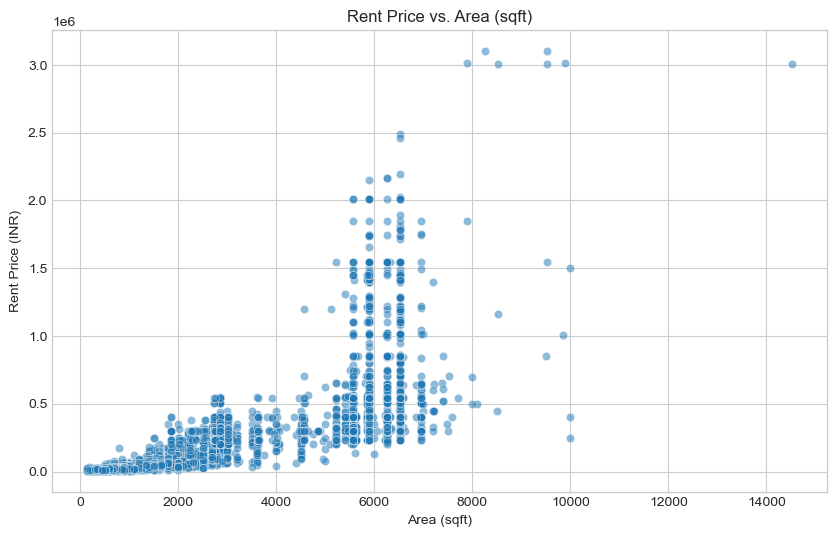


Rent Price by Property Type:


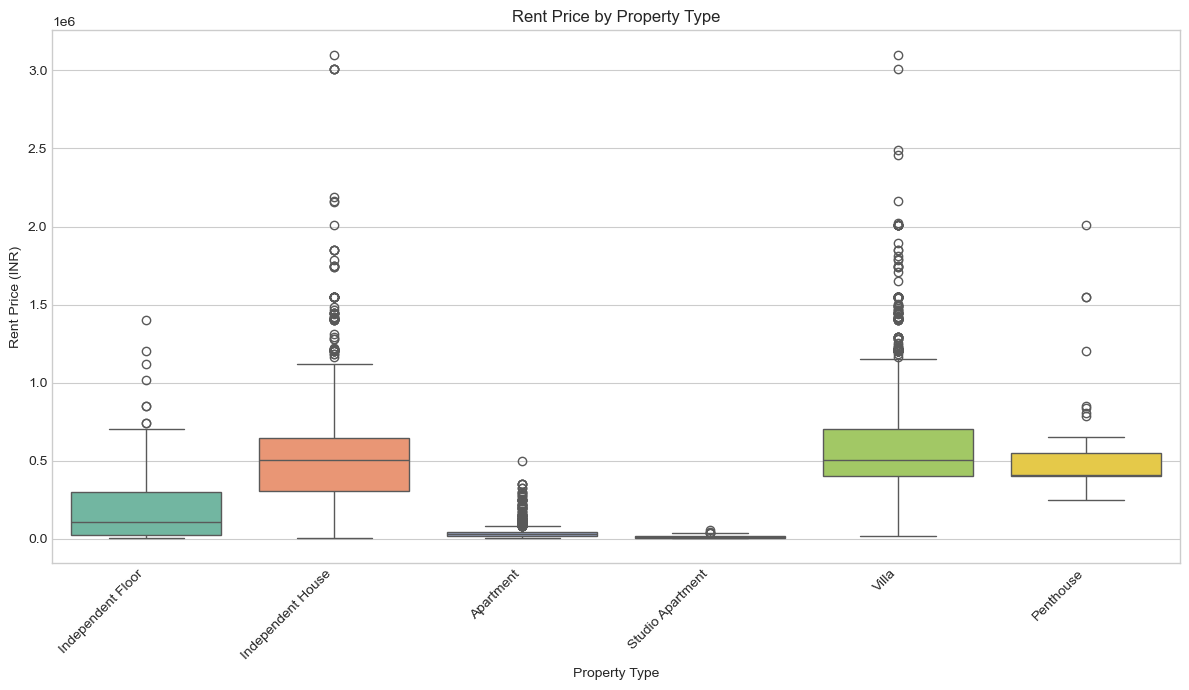


Rent Price by Number of Bathrooms:


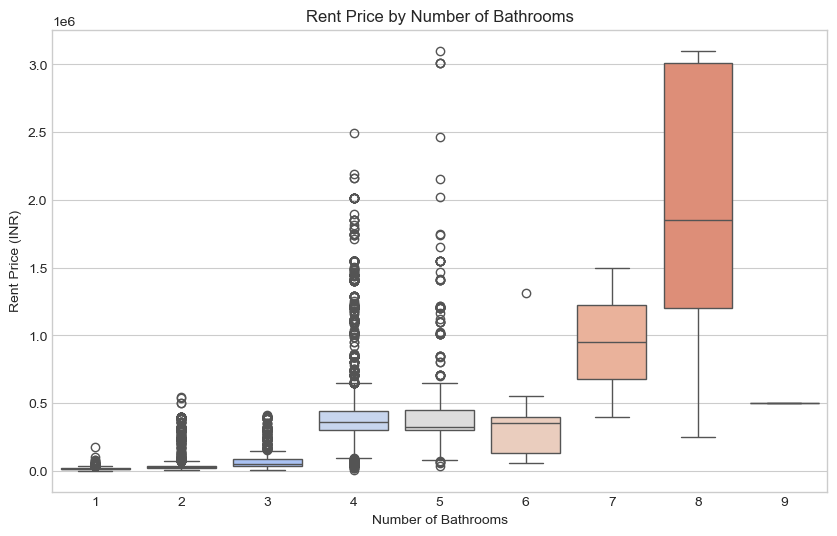

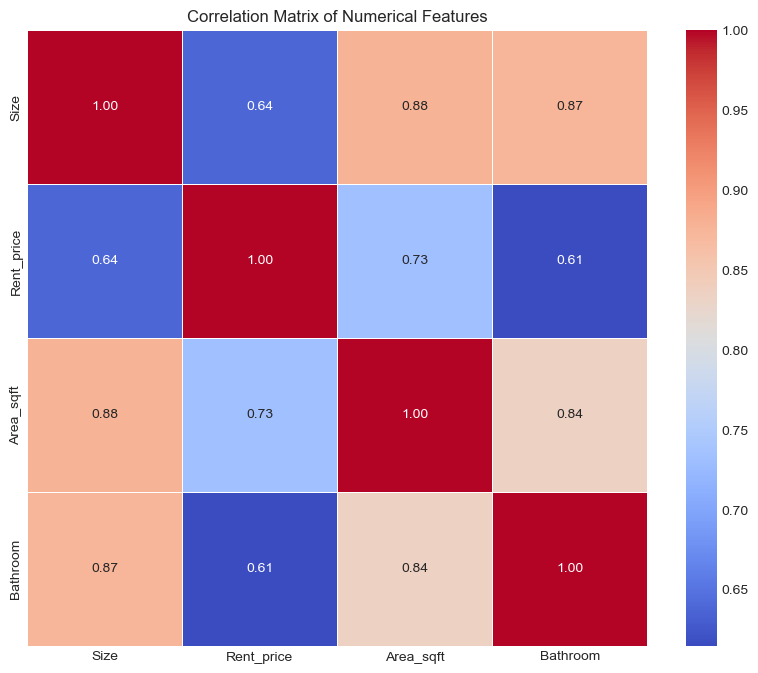


EDA complete.


In [16]:
# Step III: Exploratory Data Analysis (EDA)
print("--- III. Exploratory Data Analysis (EDA) ---")

if not df_cleaned.empty:
    # 1. Univariate Analysis 
    if 'Rent_price' in df_cleaned.columns:
        print("\nAnalyzing target variable 'Rent_price':")
        plt.figure(figsize=(10, 5))
        sns.histplot(df_cleaned['Rent_price'], kde=True)
        plt.title('Distribution of Rent Price')
        plt.xlabel('Rent Price (INR)')
        plt.ylabel('Frequency')
        plt.show()
        print(f"Rent Price Skewness: {df_cleaned['Rent_price'].skew():.2f}")

    if 'Area_sqft' in df_cleaned.columns:
        print("\nAnalyzing 'Area_sqft':")
        plt.figure(figsize=(10, 5))
        sns.histplot(df_cleaned['Area_sqft'], kde=True)
        plt.title('Distribution of Area (sqft)')
        plt.xlabel('Area (sqft)')
        plt.ylabel('Frequency')
        plt.show()

    if 'Bathroom' in df_cleaned.columns:
        print("\nAnalyzing 'Bathroom' counts:")
        plt.figure(figsize=(8, 5))
        sns.countplot(x='Bathroom', data=df_cleaned, palette='viridis')
        plt.title('Count of Bathrooms')
        plt.xlabel('Number of Bathrooms')
        plt.ylabel('Number of Properties')
        plt.show()

    if 'Property_type' in df_cleaned.columns:
        print("\nAnalyzing 'Property_type':")
        plt.figure(figsize=(12, 6))
        df_cleaned['Property_type'].value_counts().plot(kind='bar')
        plt.title('Distribution of Property Types')
        plt.xlabel('Property Type')
        plt.ylabel('Count')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    # 2. Bivariate Analysis 
    if 'Area_sqft' in df_cleaned.columns and 'Rent_price' in df_cleaned.columns:
        print("\nRent Price vs. Area_sqft:")
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x='Area_sqft', y='Rent_price', data=df_cleaned, alpha=0.5)
        plt.title('Rent Price vs. Area (sqft)')
        plt.xlabel('Area (sqft)')
        plt.ylabel('Rent Price (INR)')
        plt.show()

    if 'Property_type' in df_cleaned.columns and 'Rent_price' in df_cleaned.columns:
        print("\nRent Price by Property Type:")
        plt.figure(figsize=(12, 7))
        sns.boxplot(x='Property_type', y='Rent_price', data=df_cleaned, palette='Set2')
        plt.title('Rent Price by Property Type')
        plt.xlabel('Property Type')
        plt.ylabel('Rent Price (INR)')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    if 'Bathroom' in df_cleaned.columns and 'Rent_price' in df_cleaned.columns:
        print("\nRent Price by Number of Bathrooms:")
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='Bathroom', y='Rent_price', data=df_cleaned, palette='coolwarm')
        plt.title('Rent Price by Number of Bathrooms')
        plt.xlabel('Number of Bathrooms')
        plt.ylabel('Rent Price (INR)')
        plt.show()

    # 3. Correlation Analysis 
    numerical_df = df_cleaned.select_dtypes(include=np.number)
    if not numerical_df.empty:
        plt.figure(figsize=(10, 8))
        correlation_matrix = numerical_df.corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
        plt.title('Correlation Matrix of Numerical Features')
        plt.show()
    else:
        print("No numerical features found for correlation analysis.")
else:
    print("df_cleaned is empty. Skipping EDA.")

print("\nEDA complete.")
df_eda_done = df_cleaned.copy()

In [17]:
print("--- IV. Feature Engineering ---")
from category_encoders import CatBoostEncoder

--- IV. Feature Engineering ---


In [21]:
from sklearn.linear_model import Ridge
import xgboost as xgb


--- II. Exploratory Data Analysis (Brief) ---


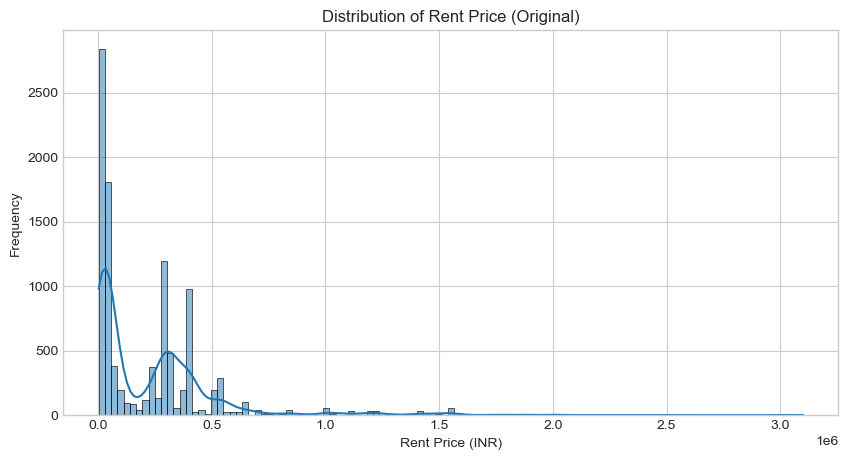

Skewness of original Rent_price: 2.94


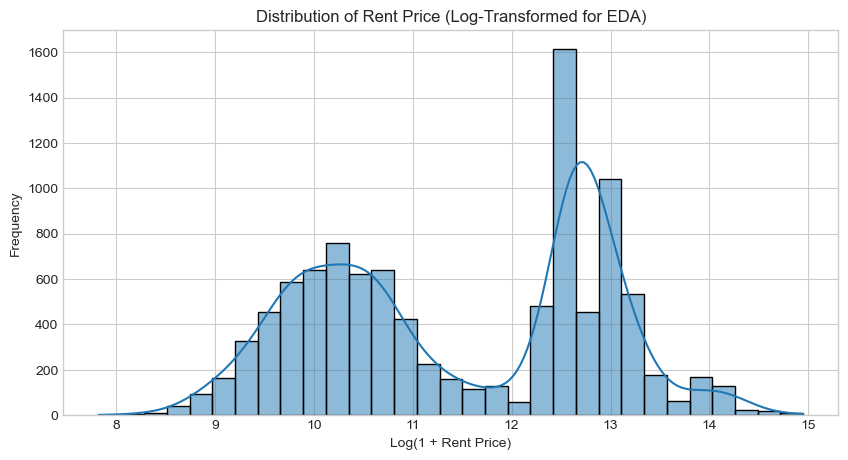

Skewness of log-transformed Rent_price: -0.05

EDA Observation:
Log-transforming 'Rent_price' significantly reduced its skewness (e.g., from a high value to near 0).
However, the log-transformed distribution appeared to be bimodal (having two distinct peaks).
Initial modeling attempts with the log-transformed target, when evaluated on the original scale 
(after back-transformation), resulted in worse RMSE and MAE compared to modeling the original 
'Rent_price' directly. This suggests that while the transformation helps with symmetry, the 
bimodality introduces complexities that the models (or the simple back-transformation) 
struggle with, leading to poorer predictive accuracy on the original scale.
Therefore, for the main modeling pipeline, we will proceed with the original 'Rent_price' 
as the target and rely on robust models or specific strategies (if bimodality persists as an issue)
rather than a global log transformation of the target.



In [ ]:
# --- II. Exploratory Data Analysis (Brief) ---
print("\n--- II. Exploratory Data Analysis (Brief) ---")

plt.figure(figsize=(10, 5))
sns.histplot(df_cleaned['Rent_price'], kde=True)
plt.title('Distribution of Rent Price (Original)')
plt.xlabel('Rent Price (INR)')
plt.ylabel('Frequency')
plt.show()
print(f"Skewness of original Rent_price: {df_cleaned['Rent_price'].skew():.2f}")

# Attempt log transformation for EDA
rent_price_log_transformed = np.log1p(df_cleaned['Rent_price'])
plt.figure(figsize=(10, 5))
sns.histplot(rent_price_log_transformed, kde=True)
plt.title('Distribution of Rent Price (Log-Transformed for EDA)')
plt.xlabel('Log(1 + Rent Price)')
plt.ylabel('Frequency')
plt.show()
print(f"Skewness of log-transformed Rent_price: {rent_price_log_transformed.skew():.2f}")



In [ ]:
# --- III. Feature Engineering Setup ---
print("\n--- III. Feature Engineering Setup ---")

X = df_cleaned.drop(['Rent_price'], axis=1) 

y = df_cleaned['Rent_price']

numerical_features_knn = []
if 'Size' in X.columns: numerical_features_knn.append('Size')
if 'Bathroom' in X.columns: numerical_features_knn.append('Bathroom')
if 'Area_sqft' in X.columns: numerical_features_knn.append('Area_sqft')

if not all(f in X.columns for f in ['Size', 'Bathroom', 'Area_sqft']):
    print("Warning: One or more of 'Size', 'Bathroom', 'Area_sqft' are missing. KNN Imputation might be affected.")
    numerical_features_knn = [f for f in ['Size', 'Bathroom', 'Area_sqft'] if f in X.columns]


categorical_ohe_features = []
for col in ['Property_type', 'Seller_type', 'Size_unit', 'Status', 'Facing_direction']:
    if col in X.columns:
        categorical_ohe_features.append(col)

catboost_feature = []
if 'Location' in X.columns:
    catboost_feature.append('Location')
else:
    print("ERROR: 'Location' column not found for CatBoostEncoding ")


all_pipeline_features = numerical_features_knn + categorical_ohe_features + catboost_feature
unknown_cols = [col for col in X.columns if col not in all_pipeline_features]
if unknown_cols:
    print(f"Warning: The following columns are in X but not assigned to a pipeline: {unknown_cols}. )

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"Numerical features for KNN & Scaling: {numerical_features_knn}")
print(f"Categorical features for OHE: {categorical_ohe_features}")
print(f"Feature for CatBoostEncoding: {catboost_feature}")


# --- IV. Preprocessing Pipelines ---
print("\n--- IV. Preprocessing Pipelines ---")

numeric_transformer = Pipeline(steps=[
    ('imputer_knn', KNNImputer()),
    ('scaler', StandardScaler())
])

ohe_transformer = Pipeline(steps=[
    ('imputer_cat', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])


transformers_list = []
has_knn_step = False
if numerical_features_knn:
    transformers_list.append(('num_knn', numeric_transformer, numerical_features_knn))
    has_knn_step = True 

has_cb_step = False
if categorical_ohe_features:
    transformers_list.append(('ohe', ohe_transformer, categorical_ohe_features))
if catboost_feature:
    transformers_list.append(('cb', CatBoostEncoder(handle_unknown='value', handle_missing='value'), catboost_feature))
    has_cb_step = True 

if not transformers_list:
    print("ERROR: No features available for preprocessing. Exiting.")
    preprocessor = None # Avoid NameError later if script continues
else:
    preprocessor = ColumnTransformer(
        transformers=transformers_list,
        remainder='drop'
    )

# --- V. Model Definition and Hyperparameter Grids ---
print("\n--- V. Model Definition and Hyperparameter Grids ---")


from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb

models_and_params = {
    'Ridge': {
        'model': Ridge(random_state=42),
        'params': {
            'regressor__alpha': [0.1, 1.0, 10.0, 50.0, 100.0]
        }
    },
    'RandomForestRegressor': {
        'model': RandomForestRegressor(random_state=42, n_jobs=-1),
        'params': {
            'regressor__n_estimators': [100, 200],
            'regressor__max_depth': [10, 20, None],
            'regressor__min_samples_split': [2, 5, 10],
            'regressor__min_samples_leaf': [1, 2, 4]
        }
    },
    'GradientBoostingRegressor': {
        'model': GradientBoostingRegressor(random_state=42),
        'params': {
            'regressor__n_estimators': [100, 200],
            'regressor__learning_rate': [0.01, 0.05, 0.1],
            'regressor__max_depth': [3, 5, 7],
            'regressor__subsample': [0.7, 0.8, 1.0]
        }
    },
    'XGBRegressor': {
        'model': xgb.XGBRegressor(random_state=42, n_jobs=-1, objective='reg:squarederror'),
        'params': {
            
            'regressor__n_estimators': [100, 150], 
            'regressor__learning_rate': [0.01, 0.05, 0.1],
            'regressor__max_depth': [3, 4, 5], 
            'regressor__colsample_bytree': [0.7, 0.8, 0.9], 
            'regressor__subsample': [0.7, 0.8, 0.9], 
            'regressor__gamma': [0, 0.1, 0.2], 
            'regressor__reg_alpha': [0, 0.01, 0.1], 
            'regressor__reg_lambda': [1, 0.1, 0.01] 
        }
    }
}


for model_name in models_and_params:
    if has_knn_step: 
   
        models_and_params[model_name]['params']['preprocessor__num_knn__imputer_knn__n_neighbors'] = [3, 5, 7, 9]
    if has_cb_step: 
        models_and_params[model_name]['params']['preprocessor__cb__sigma'] = [0.05, 0.1, 0.2, 0.4]


print("XGBoost params after conditional additions:", models_and_params['XGBRegressor']['params'])


# --- VI. GridSearchCV for Model Training and Tuning ---
print("\n--- VI. GridSearchCV for Model Training and Tuning ---")

best_estimators = {}
results_summary = []


if preprocessor is None:
    print("ERROR: Preprocessor not defined. Cannot proceed with GridSearchCV.")
    # exit() or handle
else:
    for name, config in models_and_params.items():
        print(f"\n--- Tuning {name} ---")
        model = config['model']
        param_grid = config['params']

        pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('regressor', model)])
        

        grid_search = GridSearchCV(pipeline, param_grid, cv=3, 
                                   scoring='neg_mean_squared_error', 
                                   verbose=1, n_jobs=-1)
        
        try:
            grid_search.fit(X_train, y_train)
            

            best_cv_rmse = np.sqrt(-grid_search.best_score_)
            
            print(f"Best parameters for {name}: {grid_search.best_params_}")
            print(f"Best CV RMSE (Original Scale): {best_cv_rmse:.2f}")
            
            best_estimators[name] = grid_search.best_estimator_
            
       
            y_pred_test = grid_search.predict(X_test)
            
            rmse_original = np.sqrt(mean_squared_error(y_test, y_pred_test))
            mae_original = mean_absolute_error(y_test, y_pred_test)
            r2_original = r2_score(y_test, y_pred_test)
            
            print(f"Test RMSE (Original Scale) for {name}: {rmse_original:.2f}")
            print(f"Test MAE (Original Scale) for {name}: {mae_original:.2f}")
            print(f"Test R2 (Original Scale) for {name}: {r2_original:.4f}")
            
            results_summary.append({
                'Model': name,
                'Best CV RMSE (Original)': best_cv_rmse,
                'Test RMSE (Original)': rmse_original,
                'Test MAE (Original)': mae_original,
                'Test R2 (Original)': r2_original,
                'Best Params': grid_search.best_params_
            })

        except Exception as e:
            print(f"ERROR during GridSearchCV for {name}: {e}")
            results_summary.append({
                'Model': name,
                'Best CV RMSE (Original)': np.nan,
                'Test RMSE (Original)': np.nan,
                'Test MAE (Original)': np.nan,
                'Test R2 (Original)': np.nan,
                'Best Params': str(e)
            })


# --- VII. Results Comparison ---
print("\n--- VII. Results Comparison ---")
if not results_summary:
    print("No models were tuned. Results summary is empty.")
else:
    results_df = pd.DataFrame(results_summary)
    results_df = results_df.sort_values(by='Test RMSE (Original)', ascending=True)
    print(results_df[['Model', 'Test RMSE (Original)', 'Test MAE (Original)', 'Test R2 (Original)', 'Best CV RMSE (Original)']])

    if not results_df.empty and results_df['Test RMSE (Original)'].notna().any():
        best_model_name_from_df = results_df.iloc[0]['Model'] 
        best_overall_pipeline_from_df = best_estimators.get(best_model_name_from_df) 
        print(f"\nBest overall model based on Test RMSE (Original Scale): {best_model_name_from_df}")
        if best_overall_pipeline_from_df: 
            print("Best parameters for the best model:")
            best_params_dict = results_df.iloc[0]['Best Params']
            if isinstance(best_params_dict, dict):
                 for k, v in best_params_dict.items():
                    print(f"  {k}: {v}")
            else:
                print(f"  {best_params_dict}") 
        else:
            print(f"Could not retrieve the best pipeline for {best_model_name_from_df} from 'best_estimators'. This might happen if its GridSearchCV failed.")
    else:
        print("\nNo models were successfully trained and evaluated, or results are all NaN.")
        best_overall_pipeline_from_df = None 



--- III. Feature Engineering Setup ---
X_train shape: (8136, 9), X_test shape: (2034, 9)
Numerical features for KNN & Scaling: ['Size', 'Bathroom', 'Area_sqft']
Categorical features for OHE: ['Property_type', 'Seller_type', 'Size_unit', 'Status', 'Facing_direction']
Feature for CatBoostEncoding: ['Location']

--- IV. Preprocessing Pipelines ---

--- V. Model Definition and Hyperparameter Grids ---
XGBoost params after conditional additions: {'regressor__n_estimators': [100, 150], 'regressor__learning_rate': [0.01, 0.05, 0.1], 'regressor__max_depth': [3, 4, 5], 'regressor__colsample_bytree': [0.7, 0.8, 0.9], 'regressor__subsample': [0.7, 0.8, 0.9], 'regressor__gamma': [0, 0.1, 0.2], 'regressor__reg_alpha': [0, 0.01, 0.1], 'regressor__reg_lambda': [1, 0.1, 0.01], 'preprocessor__num_knn__imputer_knn__n_neighbors': [3, 5, 7, 9], 'preprocessor__cb__sigma': [0.05, 0.1, 0.2, 0.4]}

--- VI. GridSearchCV for Model Training and Tuning ---

--- Tuning Ridge ---
Fitting 3 folds for each of 80 candidates, totalling 240 fits
Best parameters for Ridge: {'preprocessor__cb__sigma': 0.05, 'preprocessor__num_knn__imputer_knn__n_neighbors': 3, 'regressor__alpha': 50.0}
Best CV RMSE (Original Scale): 137829.08
Test RMSE (Original Scale) for Ridge: 131942.56
Test MAE (Original Scale) for Ridge: 78776.34
Test R2 (Original Scale) for Ridge: 0.7930

--- Tuning RandomForestRegressor ---
Fitting 3 folds for each of 864 candidates, totalling 2592 fits
Best parameters for RandomForestRegressor: {'preprocessor__cb__sigma': 0.05, 'preprocessor__num_knn__imputer_knn__n_neighbors': 7, 'regressor__max_depth': 10, 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 10, 'regressor__n_estimators': 200}
Best CV RMSE (Original Scale): 95588.18
Test RMSE (Original Scale) for RandomForestRegressor: 90949.09
Test MAE (Original Scale) for RandomForestRegressor: 43666.99
Test R2 (Original Scale) for RandomForestRegressor: 0.9016

--- Tuning GradientBoostingRegressor ---
Fitting 3 folds for each of 864 candidates, totalling 2592 fits
Best parameters for GradientBoostingRegressor: {'preprocessor__cb__sigma': 0.05, 'preprocessor__num_knn__imputer_knn__n_neighbors': 9, 'regressor__learning_rate': 0.05, 'regressor__max_depth': 5, 'regressor__n_estimators': 100, 'regressor__subsample': 0.7}
Best CV RMSE (Original Scale): 98531.55
Test RMSE (Original Scale) for GradientBoostingRegressor: 95310.22
Test MAE (Original Scale) for GradientBoostingRegressor: 45558.64
Test R2 (Original Scale) for GradientBoostingRegressor: 0.8920

--- Tuning XGBRegressor ---
Fitting 3 folds for each of 69984 candidates, totalling 209952 fits
Best parameters for XGBRegressor: {'preprocessor__cb__sigma': 0.05, 'preprocessor__num_knn__imputer_knn__n_neighbors': 3, 'regressor__colsample_bytree': 0.9, 'regressor__gamma': 0.1, 'regressor__learning_rate': 0.05, 'regressor__max_depth': 5, 'regressor__n_estimators': 100, 'regressor__reg_alpha': 0.1, 'regressor__reg_lambda': 1, 'regressor__subsample': 0.8}
Best CV RMSE (Original Scale): 96414.59
Test RMSE (Original Scale) for XGBRegressor: 92050.17
Test MAE (Original Scale) for XGBRegressor: 44714.89
Test R2 (Original Scale) for XGBRegressor: 0.8992

--- VII. Results Comparison ---
                       Model  Test RMSE (Original)  Test MAE (Original)  \
1      RandomForestRegressor          90949.087599         43666.988835   
3               XGBRegressor          92050.168191         44714.887717   
2  GradientBoostingRegressor          95310.224543         45558.642010   
0                      Ridge         131942.564854         78776.344741   

   Test R2 (Original)  Best CV RMSE (Original)  
1            0.901639             95588.179749  
3            0.899243             96414.593659  
2            0.891980             98531.551378  
0            0.792988            137829.078117  

Best overall model based on Test RMSE (Original Scale): RandomForestRegressor
Best parameters for the best model:
  preprocessor__cb__sigma: 0.05
  preprocessor__num_knn__imputer_knn__n_neighbors: 7
  regressor__max_depth: 10
  regressor__min_samples_leaf: 2
  regressor__min_samples_split: 10
  regressor__n_estimators: 200

In [29]:
import joblib
import os
import sklearn

MODEL_ARTIFACTS_PATH = 'trained_rental_model_artifacts.joblib'
print(f"Attempting to save artifacts to: {os.path.abspath(MODEL_ARTIFACTS_PATH)}")



print("\n--- Saving Trained Models and Artifacts ---")

      
  
if 'best_model_name_from_df' in locals() or 'best_model_name_from_df' in globals():
    current_best_model_name = best_model_name_from_df
    print(f"Best model identified as: {current_best_model_name}")
elif not results_df.empty and results_df['Test RMSE (Original)'].notna().any():
    # If best_model_name_from_df wasn't explicitly set but results_df exists, try to derive it
    results_df_sorted = results_df.sort_values(by='Test RMSE (Original)', ascending=True)
    current_best_model_name = results_df_sorted.iloc[0]['Model']
    print(f"Best model derived from results_df: {current_best_model_name}")
else:
    current_best_model_name = None
    print("Warning: Could not determine the best_model_name_from_df. It will be saved as None.")

artifacts_to_save = {
    'best_estimators': best_estimators,         
    'results_summary_df': results_df,         
    'numerical_features_knn': numerical_features_knn, 
    'categorical_ohe_features': categorical_ohe_features, 
    'catboost_feature': catboost_feature,      
    'best_overall_model_name': current_best_model_name, 
    'sklearn_version': sklearn.__version__,
    'xgboost_version': xgb.__version__,
}
        

 
if preprocessor is not None: 
    artifacts_to_save['preprocessor_template'] = preprocessor
    print("Included 'preprocessor_template' (fitted preprocessor structure) in saved artifacts.")


joblib.dump(artifacts_to_save, MODEL_ARTIFACTS_PATH)
print(f"\nSuccessfully saved artifacts to {MODEL_ARTIFACTS_PATH}")
print("These artifacts include your trained models, results, and feature definitions.")



Attempting to save artifacts to: e:\acad_doc\trained_rental_model_artifacts.joblib

--- Saving Trained Models and Artifacts ---
Best model identified as: RandomForestRegressor
Included 'preprocessor_template' (fitted preprocessor structure) in saved artifacts.

Successfully saved artifacts to trained_rental_model_artifacts.joblib
These artifacts include your trained models, results, and feature definitions.


In [30]:
import joblib

MODEL_ARTIFACTS_PATH = 'trained_rental_model_artifacts.joblib'


loaded_artifacts = joblib.load(MODEL_ARTIFACTS_PATH)
    
best_estimators = loaded_artifacts['best_estimators']
results_df = loaded_artifacts['results_summary_df']
numerical_features_knn = loaded_artifacts['numerical_features_knn']
categorical_ohe_features = loaded_artifacts['categorical_ohe_features']
catboost_feature = loaded_artifacts['catboost_feature']
best_overall_model_name = loaded_artifacts['best_overall_model_name']
    
print("Successfully loaded artifacts.")
print(f"Sklearn version used for training: {loaded_artifacts.get('sklearn_version', 'N/A')}")
print(f"XGBoost version used for training: {loaded_artifacts.get('xgboost_version', 'N/A')}")
print(f"Best overall model was: {best_overall_model_name}")
    

if best_overall_model_name and best_overall_model_name in best_estimators:
    my_best_pipeline = best_estimators[best_overall_model_name]
    print(f"\nLoaded pipeline for the best model ('{best_overall_model_name}'):")
    print(my_best_pipeline)
        

# predictions = my_best_pipeline.predict(X_new)
# print(f"Predictions: {predictions[:5]}")
elif best_estimators:
    print("\nBest overall model name not found or specified, but other models are available in 'best_estimators'.")
    print(f"Available models: {list(best_estimators.keys())}")



Successfully loaded artifacts.
Sklearn version used for training: 1.4.2
XGBoost version used for training: 2.1.1
Best overall model was: RandomForestRegressor

Loaded pipeline for the best model ('RandomForestRegressor'):
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_knn',
                                                  Pipeline(steps=[('imputer_knn',
                                                                   KNNImputer(n_neighbors=7)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Size', 'Bathroom',
                                                   'Area_sqft']),
                                                 ('ohe',
                                                  Pipeline(steps=[('imputer_cat',
                                                                  

In [40]:
input_dict={'Property_type':'Independent Floor', 'Seller_type':'Owner', 'Size_unit':'BHK','Status':'Furnished','Facing_direction':'North','Size' :2,'Bathroom':1,'Area_sqft':350,'Location':'Lajpat Nagar' }
input_df_raw = pd.DataFrame([input_dict])
predictions = my_best_pipeline.predict(input_df_raw)
print(f"Predictions: {predictions[:5]}")

Predictions: [17936.2957136]
